In [10]:
%pip install tqdm matplotlib pillow seaborn pandas numpy torch torchvision torchsummary


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [25]:
%pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu129

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu129
Note: you may need to restart the kernel to use updated packages.


In [14]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu129


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu129
   ---------------------------------------- 0.0/4.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.3 MB ? eta -:--:--
   -- ------------------------------------- 0.3/4.3 MB ? eta -:--:--
   ------- -------------------------------- 0.8/4.3 MB 2.4 MB/s eta 0:00:02
   --------------------- ------------------ 2.4/4.3 MB 4.6 MB/s eta 0:00:01
   ---------------------------------- ----- 3.7/4.3 MB 5.0 MB/s eta 0:00:01
   ---------------------------------------- 4.3/4.3 MB 4.7 MB/s  0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Standard libraries
import os
import random
from tqdm.notebook import tqdm

# Data manipulation and visualization
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np

# Deep Learning libraries
import torch
import torchvision
import torchsummary
from torch.utils import data
from torchvision import datasets, models, transforms
import torch.nn as nn
import urllib.request
import zipfile
from torchinfo import summary

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

In [2]:
import sys
print(sys.executable)


c:\Python313\python.exe


In [3]:
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Torch version: 2.8.0+cu129
CUDA available: True
GPU: NVIDIA GeForce GTX 1650


In [4]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: NVIDIA GeForce GTX 1650


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [9]:
# Download EuroSAT dataset
url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"
urllib.request.urlretrieve(url, "EuroSAT.zip")

# Unzip the file
with zipfile.ZipFile("EuroSAT.zip", 'r') as zip_ref:
    zip_ref.extractall("EuroSAT/")

# Remove the zip file
os.remove("EuroSAT.zip")

print("EuroSAT dataset downloaded and extracted successfully.")

EuroSAT dataset downloaded and extracted successfully.


In [5]:
class EuroSAT(data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        # Apply image transformations
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        # Get class label
        y = dataset[index][1]
        return x, y

    def __len__(self):
        return len(dataset)

In [6]:
input_size = 224
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

In [7]:
# Load the dataset
data_dir = './EuroSAT/2750/'
dataset = datasets.ImageFolder(data_dir)

# Get LULC categories
class_names = dataset.classes
print("Class names: {}".format(class_names))
print("Total number of classes: {}".format(len(class_names)))

Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total number of classes: 10


In [8]:
# Apply different transformations to the training and test sets
train_data = EuroSAT(dataset, train_transform)
val_data = EuroSAT(dataset, val_transform)
test_data = EuroSAT(dataset, test_transform)

# Randomly split the dataset into 70% train / 15% val / 15% test
# by subsetting the transformed train and test datasets
train_size = 0.70
val_size = 0.15
indices = list(range(int(len(dataset))))
train_split = int(train_size * len(dataset))
val_split = int(val_size * len(dataset))
np.random.shuffle(indices)

train_data = data.Subset(train_data, indices=indices[:train_split])
val_data = data.Subset(val_data, indices=indices[train_split: train_split+val_split])
test_data = data.Subset(test_data, indices=indices[train_split+val_split:])
print("Train/val/test sizes: {}/{}/{}".format(len(train_data), len(val_data), len(test_data)))

Train/val/test sizes: 18900/4050/4050


In [9]:
num_workers = 0
batch_size = 16

train_loader = data.DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
val_loader = data.DataLoader(
    val_data, batch_size=batch_size, num_workers=num_workers, shuffle=False
)
test_loader = data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

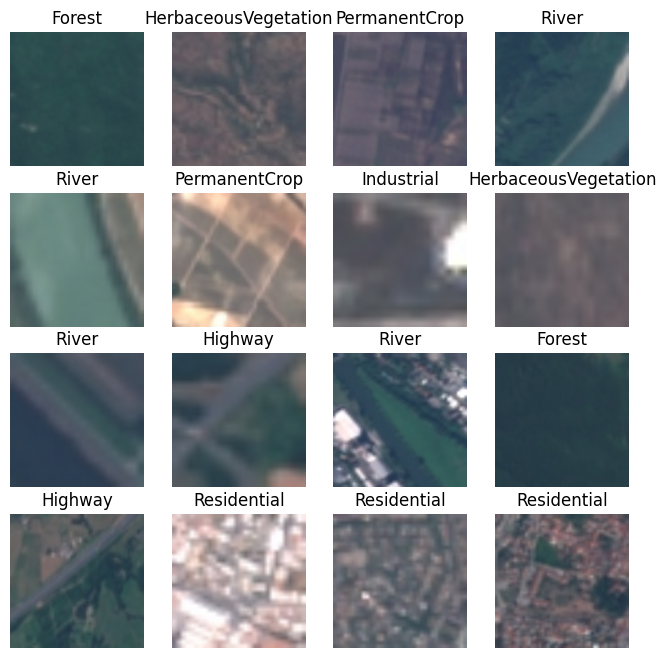

In [10]:
n = 4
inputs, classes = next(iter(train_loader))
fig, axes = plt.subplots(n, n, figsize=(8, 8))

for i in range(n):
  for j in range(n):
    image = inputs[i * n + j].numpy().transpose((1, 2, 0))
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

    title = class_names[classes[i * n + j]]
    axes[i, j].imshow(image)
    axes[i, j].set_title(title)
    axes[i, j].axis('off')

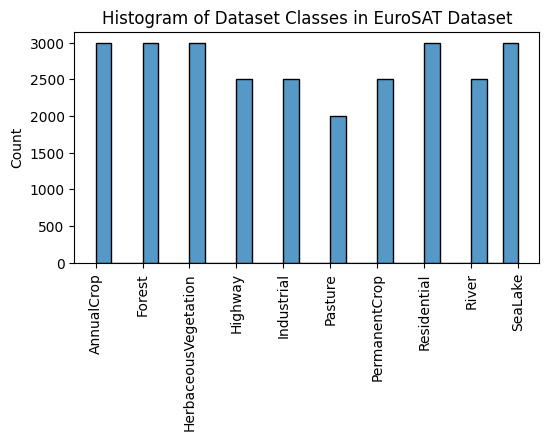

In [11]:
plt.figure(figsize=(6, 3))
hist = sns.histplot(dataset.targets)

hist.set_xticks(range(len(dataset.classes)))
hist.set_xticklabels(dataset.classes, rotation=90)
hist.set_title('Histogram of Dataset Classes in EuroSAT Dataset')

plt.show()

In [12]:

class HybridCNNTransformer(nn.Module):
    def __init__(self, num_classes, pretrained=True, num_layers=4, nhead=8, hidden_dim=2048):
        super(HybridCNNTransformer, self).__init__()

        # --- CNN Backbone (ResNet50) ---
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
        self.cnn_backbone = nn.Sequential(*list(resnet.children())[:-2])  
        # removes avgpool + fc → output = (B, 2048, 7, 7) for 224x224 input

        self.feature_dim = hidden_dim  # usually 2048 for resnet50

        # --- Flatten CNN feature map into sequence ---
        # 7x7 = 49 patches
        self.patch_dim = 7 * 7
        self.flatten = nn.Flatten(2)  # (B, 2048, 49)
        self.transpose = lambda x: x.transpose(1, 2)  # (B, 49, 2048)

        # --- Positional Encoding ---
        self.pos_embedding = nn.Parameter(torch.randn(1, self.patch_dim + 1, self.feature_dim))

        # --- CLS token ---
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.feature_dim))

        # --- Transformer Encoder ---
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.feature_dim,
            nhead=nhead,
            dim_feedforward=4096,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # --- Classification Head ---
        self.fc = nn.Linear(self.feature_dim, num_classes)

    def forward(self, x):
        # 1. CNN feature extraction
        features = self.cnn_backbone(x)  # (B, 2048, 7, 7)

        # 2. Flatten → (B, 2048, 49)
        features = self.flatten(features)

        # 3. Transpose to sequence format → (B, 49, 2048)
        features = self.transpose(features)

        # 4. Add CLS token
        B = features.size(0)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, 2048)
        tokens = torch.cat((cls_tokens, features), dim=1)  # (B, 50, 2048)

        # 5. Add positional encoding
        tokens = tokens + self.pos_embedding[:, :tokens.size(1), :]

        # 6. Transformer
        transformer_out = self.transformer(tokens)  # (B, 50, 2048)

        # 7. Classification using CLS token
        out = self.fc(transformer_out[:, 0, :])  # (B, num_classes)
        return out

In [13]:
from torchinfo import summary

In [14]:
model = HybridCNNTransformer(num_classes=len(dataset.classes)).to(device)
# model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))
model = model.to(device)

summary(model, input_size=(1, 3, 224, 224))
# torchsummary.summary(model, (3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
HybridCNNTransformer                               [1, 10]                   104,448
├─Sequential: 1-1                                  [1, 2048, 7, 7]           --
│    └─Conv2d: 2-1                                 [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                            [1, 64, 112, 112]         128
│    └─ReLU: 2-3                                   [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                              [1, 64, 56, 56]           --
│    └─Sequential: 2-5                             [1, 256, 56, 56]          --
│    │    └─Bottleneck: 3-1                        [1, 256, 56, 56]          75,008
│    │    └─Bottleneck: 3-2                        [1, 256, 56, 56]          70,400
│    │    └─Bottleneck: 3-3                        [1, 256, 56, 56]          70,400
│    └─Sequential: 2-6                             [1, 512, 28, 28]          --
│    │    └─Bo

In [15]:
# Specify number of epochs and learning rate
n_epochs = 2
lr = 1e-3

# Specify criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [17]:
def train(model, dataloader, criterion, optimizer):
  model.train()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Zero the parameter gradients
    # Clear off previous weights in order
    # to obtain updated weights.
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)

    # Compute the loss
    loss = criterion(outputs, labels)

    # Compute the gradients wrt the loss
    loss.backward()

    # Update the weights based on the
    # internally stored gradients
    optimizer.step()

    # Calculate statistics
    _, preds = torch.max(outputs, 1)

    # Calculate running loss and accuracy
    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print(f"Train Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")

  return epoch_loss, epoch_accuracy

In [18]:
def evaluate(model, dataloader, criterion, phase="val"):
  model.eval()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print(f"{phase.title()} Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")

  return epoch_loss, epoch_accuracy

In [19]:
def fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer):
  # Keep track of the best loss and
  # best model weights with the lowest loss
  best_loss = np.inf
  best_model = None

  # Train and test over n_epochs
  for epoch in range(n_epochs):
    print("Epoch {}".format(epoch+1))
    train(model, train_loader, criterion, optimizer)
    val_loss, _ = evaluate(model, val_loader, criterion)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model = model

  return best_model

In [20]:
best_model = fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer)

Epoch 1


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 1.32; Accuracy: 55.71


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.94; Accuracy: 65.85
Epoch 2


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.67; Accuracy: 77.24


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.39; Accuracy: 87.63


In [21]:
test_loss, _ = evaluate(best_model, test_loader, criterion, phase="test")

  0%|          | 0/254 [00:00<?, ?it/s]

Test Loss: 0.40; Accuracy: 87.19


In [22]:
model_dir = "./models/"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

model_file = os.path.join(model_dir, 'best_model.pth')
model_file

'./models/best_model.pth'

In [23]:
def save_model(best_model, model_file):
  torch.save(best_model.state_dict(), model_file)
  print('Model successfully saved to {}.'.format(model_file))

In [24]:
save_model(best_model, model_file)

Model successfully saved to ./models/best_model.pth.
